In [3]:
from prediction.models import ResNet
import os
import torch
import numpy as np 
from laplace import Laplace
# from analysis.cross_ds_inference import load_model

Image is valid


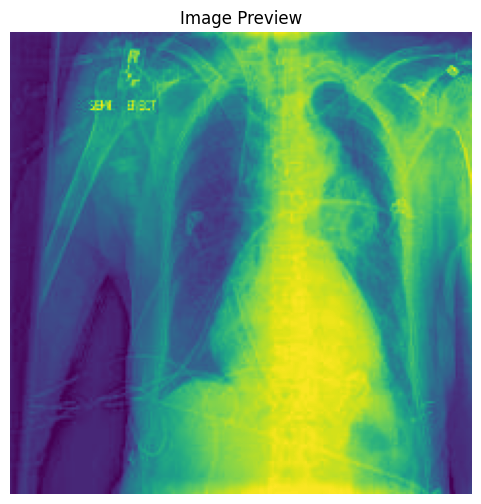

In [83]:
from PIL import Image
import matplotlib.pyplot as plt

try:
    img = Image.open("preprocess/Data/preproc_224x224/patient64365_study1_view1_frontal.jpg")
    img.verify()  
    print("Image is valid")
    img = Image.open("preprocess/Data/preproc_224x224/patient64365_study1_view1_frontal.jpg")
    plt.figure(figsize=(6, 6))  
    plt.imshow(img)
    plt.axis("off")  
    plt.title("Image Preview") 
    plt.show()

except Exception as e:
    print(f"Error opening image: {e}")


In [17]:
def preprocess_loader(data_loader):
    for batch in data_loader:
        yield batch["images"]  

train_loader_preprocessed = preprocess_loader(train_loader)


In [18]:
for batch in train_loader_preprocessed:
    print(f"Batch type: {type(batch)}")
    print(f"Batch keys: {batch.keys() if isinstance(batch, dict) else None}")
    print(f"Batch content: {batch}")
    break


Batch type: <class 'torch.Tensor'>
Batch keys: None
Batch content: tensor([[[[0.0314, 0.0275, 0.0275,  ..., 0.0118, 0.0118, 0.0118],
          [0.0314, 0.0275, 0.0275,  ..., 0.0118, 0.0118, 0.0118],
          [0.0314, 0.0275, 0.0275,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.1804, 0.2314, 0.7333,  ..., 0.0157, 0.0235, 0.0118],
          [0.3490, 0.4863, 0.7451,  ..., 0.0157, 0.0235, 0.0118],
          [0.0353, 0.1098, 0.2706,  ..., 0.0118, 0.0235, 0.0118]],

         [[0.0314, 0.0275, 0.0275,  ..., 0.0118, 0.0118, 0.0118],
          [0.0314, 0.0275, 0.0275,  ..., 0.0118, 0.0118, 0.0118],
          [0.0314, 0.0275, 0.0275,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.1804, 0.2314, 0.7333,  ..., 0.0157, 0.0235, 0.0118],
          [0.3490, 0.4863, 0.7451,  ..., 0.0157, 0.0235, 0.0118],
          [0.0353, 0.1098, 0.2706,  ..., 0.0118, 0.0235, 0.0118]],

         [[0.0314, 0.0275, 0.0275,  ..., 0.0118, 0.0118, 0.0118],
          [0.0314, 0.0275, 0.0275,  ..., 

In [19]:
for batch in train_loader_preprocessed:
    print(f"Preprocessed tensor shape: {batch.shape}")
    break


Preprocessed tensor shape: torch.Size([32, 3, 224, 224])


In [23]:
def preprocess_loader(data_loader):
    for batch in data_loader:
        images = batch["images"]
        labels = batch["labels"]  # Assuming 'labels' key exists in the batch dictionary
        yield images, labels



In [144]:
train_loader_preprocessed = preprocess_loader(train_loader)

for images, labels in train_loader_preprocessed:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break


Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32, 1])


In [31]:
import os
import torch
from laplace import Laplace
from prediction.models import ResNet
from dataloader.dataloader1 import CheXpertDataResampleModule

# Hyperparameters and settings
hp_default_value = {
    'model': 'resnet',
    'model_scale': '50',
    'lr': 1e-6,
    'bs': 64,
    'epochs': 20,
    'pretrained': True,
    'augmentation': True,
    'is_multilabel': False,
    'image_size': (224, 224),
    'crop': None,
    'prevalence_setting': 'separate',
    'save_model': False,
    'num_workers': 2,
    'num_classes': 1
}

def load_model(ckpt_dir):
    model_choose = hp_default_value['model']
    num_classes = hp_default_value['num_classes']
    lr = hp_default_value['lr']
    pretrained = hp_default_value['pretrained']
    model_scale = hp_default_value['model_scale']

    if model_choose == 'resnet':
        model_type = ResNet

    file_list = [f for f in os.listdir(ckpt_dir) if f.endswith('.ckpt')]
    assert len(file_list) == 1, f"Expected 1 checkpoint file, but found {len(file_list)}."
    ckpt_path = os.path.join(ckpt_dir, file_list[0])
    
    model = model_type.load_from_checkpoint(
        ckpt_path,
        num_classes=num_classes,
        lr=lr,
        pretrained=pretrained,
        model_scale=model_scale
    )

    return model

# Load the pre-trained model
ckpt_dir = "prediction/run/chexpert-Pleural Effusion-fp50-npp1-rs0-image_size224/version_0/checkpoints"
assert os.path.exists(ckpt_dir), f"Checkpoint directory does not exist: {ckpt_dir}"
chexpert_model = load_model(ckpt_dir)
chexpert_model.eval()
print("CheXpert model loaded successfully.")

# Data module setup
img_data_dir = "preprocess/Data/preproc_224x224/"
csv_file_img = "datafiles/chexpert.sample.allrace.csv"
image_size = 224
pseudo_rgb = True
batch_size = 32
num_workers = 4
augmentation = True
outdir = "prediction/run/chexpert-Pleural Effusion-fp50-npp1-rs0-image_size224/"
version_no = "0"
female_perc_in_training = 50
chose_disease = "Pleural Effusion"
random_state = 42
num_classes = 1
num_per_patient = 1
prevalence_setting = 'separate'
isFlip = False

data_module = CheXpertDataResampleModule(
    img_data_dir=img_data_dir,
    csv_file_img=csv_file_img,
    image_size=image_size,
    pseudo_rgb=pseudo_rgb,
    batch_size=batch_size,
    num_workers=num_workers,
    augmentation=augmentation,
    outdir=outdir,
    version_no=version_no,
    female_perc_in_training=female_perc_in_training,
    chose_disease=chose_disease,
    random_state=random_state,
    num_classes=num_classes,
    num_per_patient=num_per_patient,
    prevalence_setting=prevalence_setting,
    isFlip=isFlip
)

train_loader = data_module.train_dataloader()

# Wrap the model for dict-like input
class MyResNet18(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model

    def forward(self, data):
        device = next(self.parameters()).device
        images = data["images"].to(device)
        return self.model(images)

# Initialize wrapped model
wrapped_model = MyResNet18(chexpert_model)
wrapped_model.eval()

# Disable gradients for all layers except the last layer
for param in wrapped_model.parameters():
    param.requires_grad = False

for param in wrapped_model.model.model.fc.parameters():
    param.requires_grad = True



Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint prediction/run/chexpert-Pleural Effusion-fp50-npp1-rs0-image_size224/version_0/checkpoints/epoch=8-step=2412.ckpt`


CheXpert model loaded successfully.


/Users/fridajorgensen/Documents/GitHub/detecting_causes_of_gender_bias_chest_xrays/dataloader/dataloader1.py:840: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.csv_file_img, header=0)


DEBUG                      Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
patient_id   sex                                                              
patient00001 Female                         0.0           0.0           0.0   
patient00002 Female                         0.0           0.0           1.0   
patient00003 Male                           0.0           0.0           0.0   
patient00004 Female                         0.0           0.0           0.0   
patient00005 Male                           0.0           0.0           0.0   
...                                         ...           ...           ...   
patient64533 Male                           0.0           0.5           0.0   
patient64534 Male                           0.0           0.0           1.0   
patient64535 Male                           0.0           0.0           1.0   
patient64536 Female                         0.0           0.0           0.0   
patient64537 Male                           0.

/Users/fridajorgensen/Documents/GitHub/detecting_causes_of_gender_bias_chest_xrays/dataloader/dataloader1.py:884: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.csv_file_img, header=0)


PATIENT WISE disease prevalence
Disease prevalence total: {'Enlarged Cardiomediastinum': 0.10921150971599403, 'Cardiomegaly': 0.17848467862481315, 'Lung Opacity': 0.56273355754858, 'Lung Lesion': 0.0763421773791729, 'Edema': 0.31133221225710017, 'Consolidation': 0.1292351768809168, 'Pneumonia': 0.06086509715994021, 'Atelectasis': 0.2784317389138017, 'Pneumothorax': 0.10784130543099153, 'Pleural Effusion': 0.4078070503238665, 'Pleural Other': 0.029942077727952168, 'Fracture': 0.07450485799701047}
Disease prevalence Female: {'Enlarged Cardiomediastinum': 0.09545136459062281, 'Cardiomegaly': 0.16994401679496152, 'Lung Opacity': 0.5590972708187544, 'Lung Lesion': 0.07655703289013296, 'Edema': 0.313925822253324, 'Consolidation': 0.12393282015395381, 'Pneumonia': 0.05867739678096571, 'Atelectasis': 0.26168649405178446, 'Pneumothorax': 0.10076976906927922, 'Pleural Effusion': 0.40528341497550735, 'Pleural Other': 0.0258222533240028, 'Fracture': 0.06452064380685794}
Disease prevalence Male: {'

Loading Data: 100%|██████████| 17100/17100 [00:01<00:00, 13341.86it/s]

#train:  17098
#val:    2849
#test:   17100


In [41]:

# Laplace setup for last layer
la = Laplace(
    wrapped_model,
    likelihood="classification",
    subset_of_weights="last_layer",
    hessian_structure="diag"
)





In [51]:
from torch.utils.data import Dataset, DataLoader

class PreprocessedDataset(Dataset):
    def __init__(self, data_loader):
        self.data = []
        for batch in data_loader:
            images = batch["images"]
            labels = batch["labels"]
            for i in range(images.size(0)): 
                self.data.append({"images": images[i], "labels": labels[i]})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        return {"images": data_point["images"], "labels": data_point["labels"]}

In [53]:
preprocessed_dataset = PreprocessedDataset(train_loader)
train_loader_preprocessed = DataLoader(preprocessed_dataset, batch_size=32)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/fridajorgensen/opt/anaconda3/envs/SV/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/fridajorgensen/opt/anaconda3/envs/SV/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc5b4037a60>
Traceback (most recent call last):
  File "/Users/fridajorgensen/opt/anaconda3/envs/SV/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/fridajorgensen/opt/anaconda3/envs/SV/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object 

In [54]:
# Fit Laplace
la.fit(train_loader_preprocessed)
hessian_diag = la.H
np.save('hessian_MD_test.npy', hessian_diag.cpu().numpy())

In [63]:
print(hessian_diag.shape)

(512,)


In [4]:
hessian_diag = np.load('hessian_MD_test.npy')

# Hessian made on bad mini model with only checkpoint 8, for debugging sake

In [5]:
print("Loaded Hessian shape:", hessian_diag.shape)

Loaded Hessian shape: (512,)


# Hook method

In [59]:
ckpt_dir = "prediction/run/chexpert-Pleural Effusion-fp50-npp1-rs0-image_size224/version_0/checkpoints"
assert os.path.exists(ckpt_dir), f"Checkpoint directory does not exist: {ckpt_dir}"
chexpert_model = load_model(ckpt_dir)
chexpert_model.eval()
print("CheXpert model loaded successfully.")

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint prediction/run/chexpert-Pleural Effusion-fp50-npp1-rs0-image_size224/version_0/checkpoints/epoch=8-step=2412.ckpt`
/Users/fridajorgensen/opt/anaconda3/envs/SV/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/fridajorgensen/opt/anaconda3/envs/SV/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CheXpert model loaded successfully.


In [70]:
last_layer = chexpert_model.model.fc
print("Last layer:", last_layer)
last_layer_input = None

def hook(module, input, output):
    global last_layer_input
    last_layer_input = input[0] 

# Register hook
hook_handle = last_layer.register_forward_hook(hook)


with torch.no_grad():
    for batch in train_loader: 
        images = batch["images"].to(next(chexpert_model.parameters()).device)
        _ = chexpert_model.model(images)  
        break  

print("Last layer input shape:", None if last_layer_input is None else last_layer_input.shape)

hook_handle.remove()

print("Last layer input shape:", last_layer_input.shape)


Last layer: Linear(in_features=2048, out_features=1, bias=True)


Last layer input shape: torch.Size([32, 2048])
Last layer input shape: torch.Size([32, 2048])


In [79]:
target = batch["labels"].to(last_layer_input)

loss_fn = torch.nn.BCEWithLogitsLoss()
loss = loss_fn(output, target)



In [84]:
for param in last_layer.parameters():
    param.requires_grad = True

output = last_layer(last_layer_input)
loss = loss_fn(output, target)

grads = torch.autograd.grad(loss, last_layer.parameters(), create_graph=True)

hessian_diag = []
for grad in grads:
    grad_squared = grad**2 
    hess_diag = torch.autograd.grad(grad_squared.sum(), last_layer.parameters(), retain_graph=True)
    hessian_diag.append(hess_diag)

print("Hessian diagonal calculated")


Hessian diagonal calculated


Loading train_influence_sums from norm_train_influence_sums.pkl...


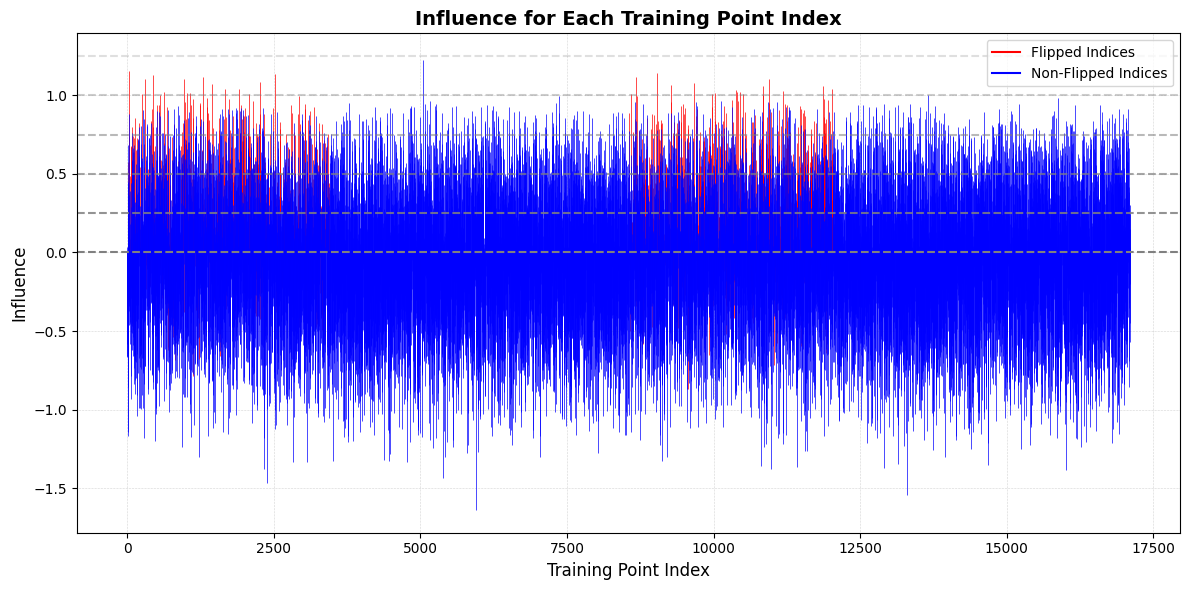

In [11]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load influence data
influence_file = "norm_train_influence_sums.pkl"
if os.path.exists(influence_file):
    print(f"Loading train_influence_sums from {influence_file}...")
    with open(influence_file, "rb") as f:
        train_influence_sums = pickle.load(f)
else:
    raise FileNotFoundError(f"{influence_file} not found. Ensure you've already computed and saved the influence data.")

# Load flipped indices
flipped_indices_file = 'train_flipped_indices_0.csv'
if os.path.exists(flipped_indices_file):
    flipped_indices_df = pd.read_csv(flipped_indices_file, header=0)
    flipped_indices = flipped_indices_df.iloc[:, 0].tolist()
    flipped_indices = [int(idx) for idx in flipped_indices]
else:
    flipped_indices = []

indices = list(train_influence_sums.keys())
influences = list(train_influence_sums.values())
flipped_influences = [train_influence_sums[idx] for idx in flipped_indices if idx in train_influence_sums]

thresholds = [0, 0.25, 0.5, 0.75, 1, 1.25]

plt.figure(figsize=(12, 6))

for idx, influence in zip(indices, [train_influence_sums[idx] for idx in indices]):
    color = 'red' if idx in flipped_indices else 'blue'
    plt.vlines(x=idx, ymin=0, ymax=influence, color=color, linewidth=0.5)

# Add thresholds
thresholds = [0, 0.25, 0.5, 0.75, 1, 1.25]
for i, threshold in enumerate(thresholds):
    alpha = 1 - 0.15 * i  
    plt.axhline(y=threshold, linestyle='--', color='gray', alpha=alpha)

# Legend
plt.plot([], [], color='red', label='Flipped Indices')
plt.plot([], [], color='blue', label='Non-Flipped Indices')
plt.legend(fontsize=10, loc="upper right")

# Axis labels and title
plt.xlabel("Training Point Index", fontsize=12)
plt.ylabel("Influence", fontsize=12)
plt.title("Influence for Each Training Point Index", fontsize=14, fontweight='bold')
plt.grid(True, linestyle=':', linewidth=0.4)
plt.tight_layout()
plt.show()